In [19]:
import os
import PIL
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from itertools import product
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
processed_images_path = "/content/drive/MyDrive/3rd Year Project/NDWI/Processed Images"
d = 1024

for image in os.listdir(processed_images_path):
    name, ext = os.path.splitext(image)
    img = Image.open(os.path.join(processed_images_path, image))
    w, h = img.size
    
    grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    for i, j in grid:
        box = (j, i, j+d, i+d)
        out = os.path.join("/content/drive/MyDrive/3rd Year Project/NDWI/Cropped", f'{name}_{i}_{j}{ext}')
        cropped_img = img.crop(box)
        np_cropped_img = np.asarray(cropped_img)

        if np.all(np_cropped_img == np_cropped_img[0]):
            continue
        else:
            cropped_img.save(out)

In [5]:
dataset_path = "/content/drive/MyDrive/3rd Year Project/NDWI/Dataset"
data_dir = pathlib.Path(dataset_path)

In [6]:
batch_size = 32
img_height = 1024
img_width = 1024

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 85 files belonging to 2 classes.
Using 68 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 85 files belonging to 2 classes.
Using 17 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['lakes', 'rivers']


In [10]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation((-0.01, 0.99), fill_mode='nearest', interpolation='bilinear'),
    layers.RandomZoom(height_factor=(0.01, 0.99), width_factor=(0.01, 0.99), fill_mode='nearest', interpolation='bilinear'),
    layers.RandomZoom(height_factor=(-0.01, -0.99), width_factor=(-0.01, -0.99), fill_mode='nearest', interpolation='bilinear'),
  ]
)

In [11]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1024, 1024, 3)     0         
                                                                 
 rescaling (Rescaling)       (None, 1024, 1024, 3)     0         
                                                                 
 conv2d (Conv2D)             (None, 1024, 1024, 16)    448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 512, 512, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 256, 256, 32)     0         
 2D)                                                  

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
3/3 [==============================] - 51s 6s/step - loss: 143.9986 - accuracy: 0.5735 - val_loss: 57.0483 - val_accuracy: 0.1765
Epoch 2/20
3/3 [==============================] - 6s 1s/step - loss: 33.5995 - accuracy: 0.3971 - val_loss: 4.7766 - val_accuracy: 0.1765
Epoch 3/20
3/3 [==============================] - 6s 1s/step - loss: 1.6975 - accuracy: 0.6176 - val_loss: 0.4643 - val_accuracy: 0.8235
Epoch 4/20
3/3 [==============================] - 6s 1s/step - loss: 0.7798 - accuracy: 0.6324 - val_loss: 0.5353 - val_accuracy: 0.8235
Epoch 5/20
3/3 [==============================] - 6s 1s/step - loss: 0.5572 - accuracy: 0.7941 - val_loss: 0.6056 - val_accuracy: 0.8235
Epoch 6/20
3/3 [==============================] - 6s 1s/step - loss: 0.5133 - accuracy: 0.8676 - val_loss: 0.5001 - val_accuracy: 0.8235
Epoch 7/20
3/3 [==============================] - 6s 1s/step - loss: 0.4429 - accuracy: 0.8382 - val_loss: 0.3259 - val_accuracy: 0.8824
Epoch 8/20
3/3 [====================

In [15]:
model.save("/content/drive/MyDrive/Colab Notebooks/NDWI_Rivers_Lakes_Trained_Model.h5")

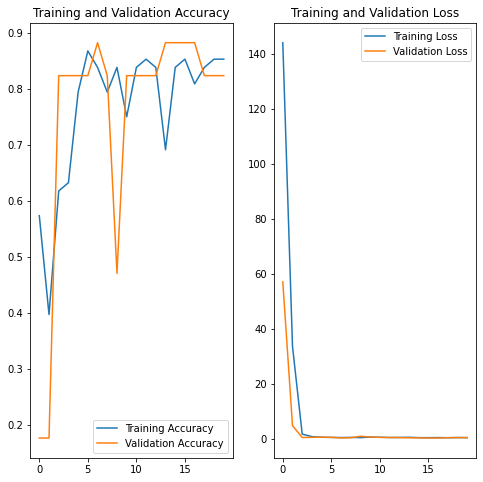

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
cropped_images_path = "/content/drive/MyDrive/3rd Year Project/NDWI/Cropped"

csv_file_path = "/content/drive/MyDrive/3rd Year Project/NDWI/Cropped_Images_Predection.csv"
csv_file = open(csv_file_path, "w")

csv_file.write("File Name, Predetction, Confidence\n")

for image in os.listdir(cropped_images_path):
    img = tf.keras.utils.load_img(
        os.path.join(cropped_images_path, image), target_size=(1024, 1024)
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    csv_file.write(image + ", " + class_names[np.argmax(score)] + ", " + str(100 * np.max(score)) + "\n")

    print(image, class_names[np.argmax(score)], 100 * np.max(score))

csv_file.close()

LC08_L2SP_142049_20210608_20210615_02_T1_SR_swir1_2048_4096.png lakes 99.91913437843323
LC08_L2SP_145043_20211222_20211230_02_T1_SR_swir1_2048_3072.png rivers 69.02062892913818
LC08_L2SP_142049_20210608_20210615_02_T1_SR_swir1_1024_1024.png rivers 80.80107569694519
LC08_L2SP_141045_20210516_20210525_02_T1_SR_swir1_0_5120.png rivers 84.95296239852905
LC08_L2SP_141045_20210516_20210525_02_T1_SR_swir2_4096_1024.png rivers 84.99204516410828
LC08_L2SP_144049_20211028_20211104_02_T1_SR_nir_2048_3072.png rivers 82.2584331035614
LC08_L2SP_141045_20210516_20210525_02_T1_SR_swir2_3072_3072.png lakes 89.16149735450745
LC08_L2SP_141045_20211023_20211103_02_T1_SR_swir2_2048_3072.png rivers 84.65812802314758
LC08_L2SP_142049_20210608_20210615_02_T1_SR_nir_0_2048.png rivers 84.09048914909363
LC08_L2SP_141047_20201207_20210313_02_T1_SR_swir2_3072_1024.png rivers 80.12586832046509
LC08_L2SP_141047_20201207_20210313_02_T1_SR_nir_0_1024.png rivers 84.20760035514832
LC08_L2SP_141045_20210516_20210525_02_T